# Определение стоимости автомобиля по VIN.

VIN состоит из `17` знаков:
- `1-3` - производитель
- `4` - ремни безопасности для пассажирских, тормоза и грузоподъемность у тракторов
- `5-7` - модель
- `8` - двигатель
- `9` - контрольный знак
- `10` - год
- `11` - завод
- `12-17` - серийный номер

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import optuna
from sklearn.ensemble import RandomForestRegressor
import optuna.visualization.matplotlib as optviz
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
import numpy as np
from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
RANDOM = 12345

## Загрузка данных

In [3]:
with open('vin_ford_train.txt') as f:
    example = f.read()
example [:1000]

'[2FMDK3JC4BBA41556:12500]РјРѕР№[3FA6P0H75ER208976:14500]РґСЏРґСЏ [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]СЃР°РјС‹С… [1FAHP2E89DG119368:11600] РІРµСЂРЅС‹С…[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]РїСЂР°РІРёР» [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600][1FDNE1BW5BDA64735:13200][3FA6P0H7XDR195494:11100][1FAHP2KT4CG139177:17300][1FMJK1J56EEF49240:36300][1FAHP2DW7AG112768:8200][1FAHP26185G158164:3800][1FTPX12584NB89868:2800][1FMCU9G90DUB02595:14400][3FAHP0HG8BR214825:8100][1ZVFT82H255209881:8000][1FTMF1CM2DKD84474:13200][1FMCU9G98DUC73580:17600][3FAHP0HA8BR154833:9900][1FTNE2EW3EDA30898:19600][1FTNF1CF3EKD47747:19000][1FM5K8D85DGA21918:18501][3FAHP0GA0AR351740:7200][1FMCU0D76CKA12182:14700][1FADP3F23EL151448:10100][1FAHP3FN2AW295660:6800][1FTRW1

In [4]:
CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
NUMS = [str(x) for x in range(1,10)] + ['0']
ALLOWED = ''.join(CHARS+NUMS)
ALLOWED

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [5]:
WMI_RE = f'(?P<wmi>[{ALLOWED}]{{3}})'
RESTRAINT_RE = f'(?P<restraint>[{ALLOWED}])'
MODEL_RE = f'(?P<model>[{ALLOWED}]{{3}})'
ENGINE_RE = f'(?P<engine>[{ALLOWED}])'
CHECK_RE = f'(?P<check>[{ALLOWED}])'
YEAR_RE = f'(?P<year>[{ALLOWED.replace("U", "").replace("Z", "")}])'
PLANT_RE = f'(?P<plant>[{ALLOWED}])'
VIS_RE = f'(?P<vis>[{ALLOWED}]{{3}}\\d{{3}})'

VIN_RE = f'{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}'
PRICE_RE = r'(?P<price>\d+)'

In [6]:
data_re = re.compile(f'\\[{VIN_RE}:{PRICE_RE}\\]')

In [7]:
df = pd.DataFrame([x.groupdict() for x in data_re.finditer(example)])
df

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600
...,...,...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,1,V,N,B73890,1000
71880,1FA,D,P3F,2,3,D,L,169365,12200
71881,3FA,6,P0H,D,2,E,R,142859,16300
71882,1FA,H,P34,N,7,6,W,128169,1500


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


In [9]:
df['price'] = pd.to_numeric(df['price'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 4.9+ MB


In [10]:
print(f'Дубликатов: {df.duplicated().sum()}')

Дубликатов: 0


In [11]:
df = df.drop(['vis', 'check'], axis=1)

In [12]:
def plot_dataframe(df, column):
    # Создание графиков
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Box plot для столбца
    axes[0].set_title(
        f'Boxplot для столбца {column}', fontsize=15, color='DarkSlateGray')
    sns.boxplot(data=df, y=column, ax=axes[0])
    axes[0].set_xlabel('Количество', fontsize=15, color='DarkSlateGray')
    axes[0].set_ylabel(column, fontsize=15, color='DarkSlateGray')
    axes[0].grid(True)
    axes[0].minorticks_on()
    axes[0].grid(which='minor', linestyle=':')

    # Histogram plot для столбца
    axes[1].set_title(
        f'Histogram plot для столбца {column}', fontsize=15, color='DarkSlateGray')
    sns.histplot(df[column], kde=False, bins=50, ax=axes[1])
    axes[1].set_ylabel('Количество', fontsize=15, color='DarkSlateGray')
    axes[1].set_xlabel(column, fontsize=15, color='DarkSlateGray')

    # Отображение графиков
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':')
    plt.grid(True)
    plt.show()

    # Подсчет уникальных значений и их количества
    unique_vals = df[column].unique()
    count = df[column].value_counts()
    describ = df[column].describe()
    print(describ)
    print('*'*100)
    print(f"Уникальные значения столбца {column}: {unique_vals}")
    print('*'*100)
    print(f"Количество каждого уникального значения: \n{count}")

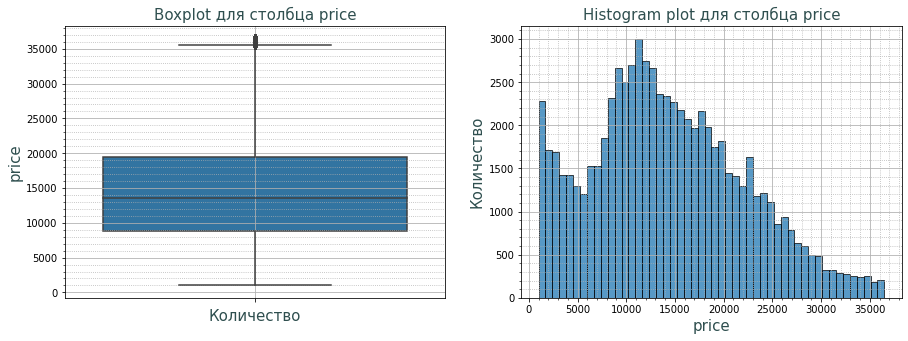

count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64
****************************************************************************************************
Уникальные значения столбца price: [12500 14500  1300 15200 11600 26400 14000 19500 24400  2900 23500 12700
 20700 21300 26700 25100 13200 11100 17300 36300  8200  3800  2800 14400
  8100  8000 17600  9900 19600 19000 18501  7200 14700 10100  6800 17900
 20800 12800  1050  6000 20100 10500  7600  3600 20200 15100  9500 24500
 16250  9700 24000 34500 13500  7700  4300 18500  3100 28000 21800 22300
  9800 21500 25800  1900 15400 22200 18200  3200 28400 21900 12300 11900
  6600 18300  6100 17250 23300 11800 17400 14300 33500 20500  4400 12900
  6300 14200 13700 12400 10000 14100 14600  2000 22700 18800  8500  3500
  6200 21000  2200 17800  2700  9300 19700 11400 21400  2300  9000  8300
 10

In [13]:
plot_dataframe(df, 'price')

In [14]:
def analyze_column(df, column):
    """
    Функция для анализа уникальных значений и их количества в указанном столбце DataFrame.

    Параметры:
    - df: DataFrame, в котором нужно анализировать данные.
    - column: строка, имя столбца для анализа.
    """
    # Получение уникальных значений
    unique_vals = df[column].unique()
    
    # Подсчет количества каждого уникального значения
    count = df[column].value_counts()
    
    # Получение статистической информации о столбце
    describ = df[column].describe()
    
    # Вывод результатов
    print('*'*100)
    print(f"Cтатистическая информация о столбце {column}: {describ}")
    print('*'*100)
    print(f"Уникальные значения столбца {column}: {unique_vals}")
    print('*'*100)
    print(f"Количество каждого уникального значения: \n{count}")

In [15]:
analyze_column(df, 'wmi')
analyze_column(df, 'restraint')
analyze_column(df, 'model')
analyze_column(df, 'engine')
analyze_column(df, 'year')
analyze_column(df, 'plant')

****************************************************************************************************
Cтатистическая информация о столбце wmi: count     71884
unique       14
top         1FM
freq      18347
Name: wmi, dtype: object
****************************************************************************************************
Уникальные значения столбца wmi: ['2FM' '3FA' '1FM' '1FA' '1FT' '1ZV' '1FD' '2FA' '2FT' '1FB' '4F2' '4F4'
 '3FT' '4N2']
****************************************************************************************************
Количество каждого уникального значения: 
1FM    18347
1FT    17177
1FA    12844
3FA    12404
2FM     5829
1ZV     3257
1FB     1124
4F2      263
1FD      242
2FA      199
2FT      145
4N2       22
4F4       16
3FT       15
Name: wmi, dtype: int64
****************************************************************************************************
Cтатистическая информация о столбце restraint: count     71884
unique       26
top           D
fre

In [16]:
def remove_single_unique_values(df, column):
    """
    Функция для удаления единичных уникальных значений из указанного столбца DataFrame.

    Параметры:
    - df: DataFrame, в котором нужно удалить данные.
    - column: строка, имя столбца для анализа.

    Возвращает:
    - DataFrame с удаленными единичными уникальными значениями.
    """
    # Находим единичные уникальные значения
    single_unique_values = df[column].value_counts() == 1

    # Создаем список значений, которые нужно удалить
    values_to_remove = single_unique_values[single_unique_values].index

    # Удаляем эти значения
    df = df[~df[column].isin(values_to_remove)]
    
    return df

In [17]:
df = remove_single_unique_values(df, 'year')

In [18]:
df = remove_single_unique_values(df, 'restraint')

In [19]:
analyze_column(df, 'model')

****************************************************************************************************
Cтатистическая информация о столбце model: count     71880
unique      365
top         P0H
freq       6171
Name: model, dtype: object
****************************************************************************************************
Уникальные значения столбца model: ['K3J' 'P0H' 'P08' 'U0G' 'P2E' 'K8D' 'W1C' 'U64' 'U9D' 'U9E' 'U0J' 'K5D'
 'K4K' 'X1E' 'P8E' 'E1B' 'P2K' 'K1J' 'P2D' 'P26' 'X12' 'U9G' 'T82' 'F1C'
 'E2E' 'P0G' 'U0D' 'P3F' 'W14' 'P0R' 'U31' 'F20' 'P3K' 'K3G' 'U15' 'U17'
 'P0L' 'U9J' 'U0F' 'P0J' 'W21' 'W1E' 'K8G' 'W12' 'R1A' 'P4E' 'F12' 'U73'
 'K4J' 'P53' 'P2F' 'K5C' 'U0H' 'X18' 'R14' 'P34' 'P74' 'F17' 'S3B' 'U63'
 'Z96' 'P3E' 'A52' 'P8A' 'U62' 'K05' 'E24' 'K3K' 'P07' 'K7F' 'E1E' 'T80'
 'K18' 'W07' 'P24' 'W4D' 'K7D' 'K15' 'U18' 'U0E' 'K6C' 'X21' 'W3B' 'K5B'
 'R1E' 'P40' 'K6D' 'P4B' 'E34' 'U92' 'K1H' 'P3H' 'P35' 'K8F' 'U04' 'R10'
 'P42' 'Z02' 'P3M' 'P45' 'U67' 'U9C' 'P11' 'E

In [20]:
df = remove_single_unique_values(df, 'model')

In [21]:
df 

,wmi,restraint,model,engine,year,plant,price
0,2FM,D,K3J,C,B,B,12500
1,3FA,6,P0H,7,E,R,14500
2,3FA,H,P08,Z,7,R,1300
3,1FM,C,U0G,X,D,U,15200
4,1FA,H,P2E,8,D,G,11600
...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,V,N,1000
71880,1FA,D,P3F,2,D,L,12200
71881,3FA,6,P0H,D,E,R,16300
71882,1FA,H,P34,N,6,W,1500


In [22]:
# Предполагается, что df, RANDOM уже определены
_train_ohe, _test_ohe = train_test_split(
    df, test_size=0.2, random_state=RANDOM)

cat_features = ['wmi', 'restraint', 'model', 'engine', 'plant', 'year']

ohe_encoder = OneHotEncoder(drop='first', sparse=False)

# обучили на трейне и сразу к нему применили
train_temp = ohe_encoder.fit_transform(_train_ohe[cat_features])
# вписали новые признаки
_train_ohe[ohe_encoder.get_feature_names()] = train_temp
_train_ohe.drop(cat_features, axis=1, inplace=True)  # удалили старые признаки

# обученный энкодер применили к тест. выборке
test_temp = ohe_encoder.transform(_test_ohe[cat_features])
# вписали новые признаки
_test_ohe[ohe_encoder.get_feature_names()] = test_temp
_test_ohe.drop(cat_features, axis=1, inplace=True)  # удалили старые признаки

C:\Temp\ipykernel_8812\1053352862.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _train_ohe[ohe_encoder.get_feature_names()] = train_temp
C:\Users\Андрей Владимирович\practicum\practicum_env\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Андрей Владимирович\practicum\practicum_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [23]:
_test_ohe

,price,x0_1FB,x0_1FD,x0_1FM,x0_1FT,x0_1ZV,x0_2FA,x0_2FM,x0_2FT,x0_3FA,...,x5_D,x5_E,x5_F,x5_R,x5_S,x5_T,x5_V,x5_W,x5_X,x5_Y
27010,11800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69938,19700,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41722,11100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54827,11800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32904,7800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31031,19900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52063,23700,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40230,8300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36722,15600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
_train_ohe

,price,x0_1FB,x0_1FD,x0_1FM,x0_1FT,x0_1ZV,x0_2FA,x0_2FM,x0_2FT,x0_3FA,...,x5_D,x5_E,x5_F,x5_R,x5_S,x5_T,x5_V,x5_W,x5_X,x5_Y
51719,12600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60506,11800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20416,1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42830,4600,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65264,10900,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47887,6000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16934,10100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28013,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4095,17300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выделим целевой признак на выборках до кодирования и после.

In [25]:
target_column = 'price'
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM)
target_train = train[target_column]
features_train = train.drop([target_column], axis=1)

target_test = test[target_column]
features_test = test.drop([target_column], axis=1)

target_train_ohe = _train_ohe[target_column]
features_train_ohe = _train_ohe.drop([target_column], axis=1)

target_test_ohe = _test_ohe[target_column]
features_test_ohe = _test_ohe.drop([target_column], axis=1)

In [26]:
display(target_train)
display(features_train)
display(target_test)
display(features_test)
display(target_train_ohe)
display(features_train_ohe)
display(target_test_ohe)
display(features_test_ohe)

51719    12600
60506    11800
20416     1000
42830     4600
65264    10900
         ...  
47887     6000
16934    10100
28013    10000
4095     17300
2177      7000
Name: price, Length: 57488, dtype: int64

,wmi,restraint,model,engine,year,plant
51719,3FA,6,P0H,R,D,R
60506,1FA,D,P3K,2,E,L
20416,1FM,Y,U93,Z,7,K
42830,1FM,Y,U93,1,6,K
65264,2FM,D,K3J,C,B,B
...,...,...,...,...,...,...
47887,1FT,R,F12,W,6,N
16934,1FA,H,P3H,N,A,W
28013,1FA,D,P3F,2,E,L
4095,1ZV,B,P8E,M,E,5


27010    11800
69938    19700
41722    11100
54827    11800
32904     7800
         ...  
31031    19900
52063    23700
40230     8300
36722    15600
56686     5200
Name: price, Length: 14373, dtype: int64

,wmi,restraint,model,engine,year,plant
27010,1FA,D,P3F,2,D,L
69938,2FM,D,K3J,C,D,B
41722,1FA,D,P3K,2,D,L
54827,1FA,D,P3F,2,E,L
32904,3FA,H,P0H,A,C,R
...,...,...,...,...,...,...
31031,3FA,6,P0K,9,E,R
52063,1FT,N,S2E,W,E,D
40230,3FA,H,P0J,G,B,R
36722,3FA,6,P0H,D,E,R


51719    12600
60506    11800
20416     1000
42830     4600
65264    10900
         ...  
47887     6000
16934    10100
28013    10000
4095     17300
2177      7000
Name: price, Length: 57488, dtype: int64

,x0_1FB,x0_1FD,x0_1FM,x0_1FT,x0_1ZV,x0_2FA,x0_2FM,x0_2FT,x0_3FA,x0_3FT,...,x5_D,x5_E,x5_F,x5_R,x5_S,x5_T,x5_V,x5_W,x5_X,x5_Y
51719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20416,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42830,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47887,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4095,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


27010    11800
69938    19700
41722    11100
54827    11800
32904     7800
         ...  
31031    19900
52063    23700
40230     8300
36722    15600
56686     5200
Name: price, Length: 14373, dtype: int64

,x0_1FB,x0_1FD,x0_1FM,x0_1FT,x0_1ZV,x0_2FA,x0_2FM,x0_2FT,x0_3FA,x0_3FT,...,x5_D,x5_E,x5_F,x5_R,x5_S,x5_T,x5_V,x5_W,x5_X,x5_Y
27010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69938,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52063,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучим разные модели.

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM)

## RandomForestRegressor

[I 2024-04-22 16:37:53,541] A new study created in memory with name: no-name-52afce45-e9c0-47d5-b33e-1cc5dca76a33
[I 2024-04-22 16:38:23,890] Trial 0 finished with value: 4685.870586516447 and parameters: {'n_estimators': 226, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 4685.870586516447.
[I 2024-04-22 16:45:20,317] Trial 1 finished with value: 2853.8769565731063 and parameters: {'n_estimators': 417, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 2853.8769565731063.
[I 2024-04-22 16:46:49,783] Trial 2 finished with value: 2943.367974105764 and parameters: {'n_estimators': 228, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 2853.8769565731063.
[I 2024-04-22 16:47:13,181] Trial 3 finished with value: 4092.914714653755 and 

Лучшие параметры: {'n_estimators': 367, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Лучшее значение метрики: 2786.7476516086676


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,bootstrap,score
0,367.0,30.0,2.0,2.0,None,1.0,2786.747652


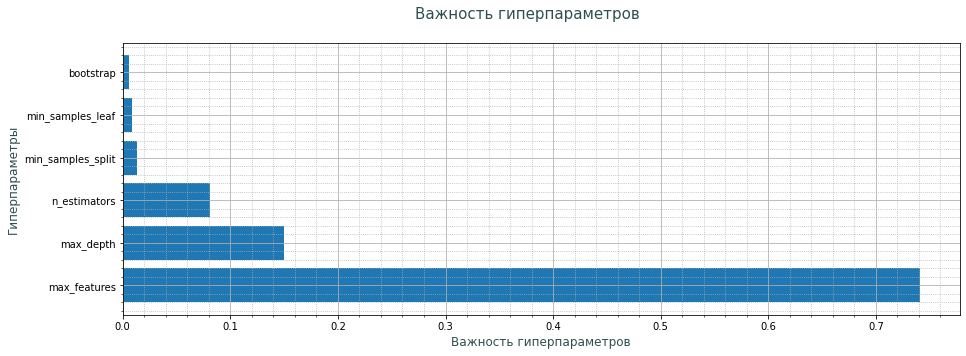

<timed exec>:76: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


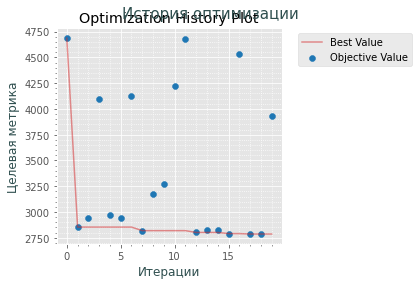

Wall time: 1h 7min 18s


In [28]:
%%time

def objective(trial):
    # Определяем параметры для подбора
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    max_features = trial.suggest_categorical(
        'max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

# Создадём модель случайного леса с определенными параметрами
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  max_features=max_features,
                                  bootstrap=bootstrap,
                                  random_state=RANDOM,
                                  n_jobs=-1)

# Оцениваем качество модели с помощью кросс-валидации
    score = (cross_val_score(model,
                             features_train_ohe,
                             target_train_ohe,
                             cv=kf,
                             scoring='neg_mean_squared_error', n_jobs=-1).mean() * -1) ** 0.5
# Возврщаем значения метрики
    return score


# Создаём объект Study и запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Лучшие параметры:', study.best_params)
print('Лучшее значение метрики:', study.best_value)

# Создаём датафрейм с значениями гиперпараметров и метрикой
results = pd.DataFrame({'n_estimators': [],
                       'max_depth': [],
                        'min_samples_split': [],
                        'min_samples_leaf': [],
                        'max_features': [],
                        'bootstrap': [],
                        'score': []})
# Заполняем данными из best_trials
for trial in study.best_trials:
    params = trial.params
    params['score'] = trial.value
    results = results.append(params, ignore_index=True)
# Сортируем датафрейм по убыванию значения метрики
results = results.sort_values(by='score', ascending=False)
# Выводим 10 лучших моделей
display(results.head(10))

# Создание графика важности параметров с помощью Optuna
importance_dict = optuna.importance.get_param_importances(study)
# Извлечение ключей и значений из словаря
keys = list(importance_dict.keys())
values = list(importance_dict.values())
# Создание горизонтального графика
plt.figure(figsize=(15, 5))
plt.barh(keys, values, color='tab:blue')
# Настройка графика
plt.xlabel('Важность гиперпараметров', fontsize=12, color='DarkSlateGray')
plt.ylabel('Гиперпараметры', fontsize=12, color='DarkSlateGray')
plt.suptitle('Важность гиперпараметров', fontsize=15, color='DarkSlateGray')
# Добавление минорных делений и сетки
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.grid(True)
# Показать график
plt.show()

#  Создаём график истории оптимизации
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.xlabel('Итерации',
           fontsize=12,
           color='DarkSlateGray')
plt.ylabel('Целевая метрика',
           fontsize=12,
           color='DarkSlateGray')
plt.suptitle('История оптимизации \n \n',
             fontsize=15,
             color='DarkSlateGray')
plt.minorticks_on()
plt.grid(which='minor',
         linestyle=':')
plt.grid(True)
plt.show()
# Сохранение модели с наилучшими параметрами
forest = RandomForestRegressor(n_estimators=study.best_params['n_estimators'],
                               max_depth=study.best_params['max_depth'],
                               min_samples_split=study.best_params['min_samples_split'],
                               min_samples_leaf=study.best_params['min_samples_leaf'],
                               max_features=study.best_params['max_features'],
                               bootstrap=study.best_params['bootstrap'],
                               random_state=RANDOM, n_jobs=-1)

In [ ]:
# Определение параметров для поиска
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=98, stop=417, num=30)],
    'max_depth': [int(x) for x in np.linspace(start=16, stop=30, num=15)],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=5, num=4)],
    'min_samples_leaf': [2],
    'max_features': [None],
    'bootstrap': [True]
}
random_search.fit(features_train_ohe, target_train_ohe)
# Создание объекта RandomForestRegressor
rf = RandomForestRegressor(random_state=RANDOM, n_jobs=-1)

# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2,
                                   random_state=RANDOM, n_jobs=-1)

# Предположим, что features_train и target_train уже определены
random_search.fit(features_train_ohe, target_train_ohe)

# Вывод лучших параметров
print("Лучшие параметры: ", random_search.best_params_)

# Оценка модели с лучшими параметрами
cv_RMSE_RF = (cross_val_score(random_search.best_estimator_,
                               features_train_ohe,
                               target_train_ohe,
                               cv=kf,
                               scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Значение метрики:', cv_RMSE_RF)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


## LGBMRegressor

In [29]:
# Определение категориальных признаков
categorical_features = ['wmi', 'restraint', 'model', 'engine', 'plant', 'year']
# Преобразование категориальных признаков в числовые значения для обучающей выборки
for feature in categorical_features:
    features_train[feature] = features_train[feature].astype('category').cat.codes
    features_test[feature] = features_test[feature].astype('category').cat.codes

def objective(trial):
    # Определяем параметры для подбора
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)
    
    # Создаем модель с определенными параметрами
    model = LGBMRegressor(n_estimators=n_estimators,
                          max_depth=max_depth,
                          min_child_samples=min_child_samples,
                          learning_rate=learning_rate,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=RANDOM)
    
    # Оцениваем качество модели с помощью кросс-валидации
    score = (cross_val_score(model,
                             features_train,
                             target_train,
                             cv=kf,
                             scoring='neg_mean_squared_error', n_jobs=-1).mean() * -1) ** 0.5
    # Возвращаем значения метрики
    return score

# Создаем объект Study и запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Лучшие параметры:', study.best_params)
print('Лучшее значение метрики:', study.best_value)

# Создаем датафрейм с значениями гиперпараметров и метрикой
results = pd.DataFrame({'n_estimators': [],
                       'max_depth': [],
                       'min_child_samples': [],
                       'learning_rate': [],
                       'subsample': [],
                       'colsample_bytree': [],
                       'score': []})
# Заполняем данными из best_trials
for trial in study.best_trials:
    params = trial.params
    params['score'] = trial.value
    results = results.append(params, ignore_index=True)

# Сортируем датафрейм по убыванию значения метрики
results = results.sort_values(by='score', ascending=False)

# Выводим 10 лучших моделей
display(results.head(10))

# Создание графика важности параметров с помощью Optuna
importance_dict = optuna.importance.get_param_importances(study)
# Извлечение ключей и значений из словаря
keys = list(importance_dict.keys())
values = list(importance_dict.values())
# Создание горизонтального графика
plt.figure(figsize=(15, 5))
plt.barh(keys, values, color='tab:blue')
# Настройка графика
plt.xlabel('Важность гиперпараметров', fontsize=12, color='DarkSlateGray')
plt.ylabel('Гиперпараметры', fontsize=12, color='DarkSlateGray')
plt.suptitle('Важность гиперпараметров', fontsize=15, color='DarkSlateGray')
# Добавление минорных делений и сетки
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.grid(True)
# Показать график
plt.show()

# Создаем график истории оптимизации
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.xlabel('Итерации',
           fontsize=12,
           color='DarkSlateGray')
plt.ylabel('Целевая метрика',
           fontsize=12,
           color='DarkSlateGray')
plt.suptitle('История оптимизации \n \n',
             fontsize=15,
             color='DarkSlateGray')
plt.minorticks_on()
plt.grid(which='minor',
         linestyle=':')
plt.grid(True)
plt.show()

[I 2024-04-22 17:45:11,839] A new study created in memory with name: no-name-643df273-b0ff-4003-b568-77323eddeae5
[W 2024-04-22 17:45:13,902] Trial 0 failed with parameters: {'n_estimators': 419, 'max_depth': 17, 'min_child_samples': 3, 'learning_rate': 0.060000000000000005, 'subsample': 0.86, 'colsample_bytree': 0.72} because of the following error: The value nan is not acceptable.
[W 2024-04-22 17:45:13,903] Trial 0 failed with value nan.
[W 2024-04-22 17:45:14,285] Trial 1 failed with parameters: {'n_estimators': 323, 'max_depth': 23, 'min_child_samples': 3, 'learning_rate': 0.02, 'subsample': 0.74, 'colsample_bytree': 0.77} because of the following error: The value nan is not acceptable.
[W 2024-04-22 17:45:14,286] Trial 1 failed with value nan.
[W 2024-04-22 17:45:14,605] Trial 2 failed with parameters: {'n_estimators': 307, 'max_depth': 30, 'min_child_samples': 2, 'learning_rate': 0.05, 'subsample': 0.88, 'colsample_bytree': 0.65} because of the following error: The value nan is 

ValueError: No trials are completed yet.

In [ ]:
# Определение категориальных признаков
categorical_features = ['wmi', 'restraint', 'model', 'engine', 'plant', 'year']

# Преобразование категориальных признаков в числовые значения для обучающей выборки
for feature in categorical_features:
    features_train[feature] = features_train[feature].astype('category').cat.codes
    features_test[feature] = features_test[feature].astype('category').cat.codes

# Определение параметров для поиска
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_child_samples': [2, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'num_leaves': [2, 10, 30]
}

# Создание объекта LGBMRegressor
lgbm = LGBMRegressor(random_state=RANDOM, n_jobs=-1)

# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=2,
                                   random_state=RANDOM, n_jobs=-1)

# Проведение поиска
random_search.fit(features_train, target_train)

# Вывод лучших параметров
print("Лучшие параметры: ", random_search.best_params_)

# Оценка модели с лучшими параметрами
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM)
cv_RMSE_LR = (cross_val_score(random_search.best_estimator_,
                              features_train,
                              target_train,
                              cv=kf,
                              scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Значение метрики:', cv_RMSE_LR)

[I 2024-04-22 17:52:36,675] A new study created in memory with name: no-name-8da83f10-96e9-4de6-a092-0a445d55018f
[I 2024-04-22 17:53:00,026] Trial 0 finished with value: 2893.546006986973 and parameters: {'iterations': 536, 'depth': 3, 'learning_rate': 0.08}. Best is trial 0 with value: 2893.546006986973.
[I 2024-04-22 17:53:15,724] Trial 1 finished with value: 3035.479545816909 and parameters: {'iterations': 509, 'depth': 2, 'learning_rate': 0.05}. Best is trial 0 with value: 2893.546006986973.
[I 2024-04-22 17:53:36,221] Trial 2 finished with value: 2874.326205105773 and parameters: {'iterations': 341, 'depth': 5, 'learning_rate': 0.05}. Best is trial 2 with value: 2874.326205105773.
[I 2024-04-22 17:54:03,364] Trial 3 finished with value: 2840.7727281405832 and parameters: {'iterations': 435, 'depth': 5, 'learning_rate': 0.060000000000000005}. Best is trial 3 with value: 2840.7727281405832.
[I 2024-04-22 17:54:24,350] Trial 4 finished with value: 2990.312677806933 and parameters: {

Лучшие параметры: {'iterations': 461, 'depth': 8, 'learning_rate': 0.06999999999999999}
Лучшее значение метрики: 2789.5006962051957


,iterations,depth,learning_rate,score
0,461.0,8.0,0.07,2789.500696


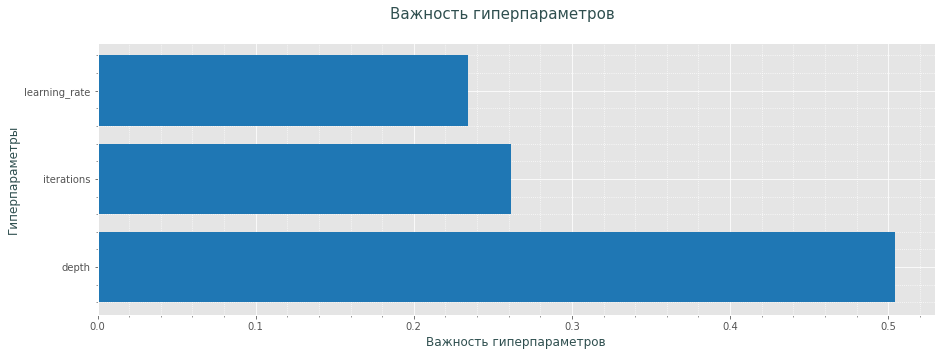

C:\Temp\ipykernel_8812\3442734128.py:75: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


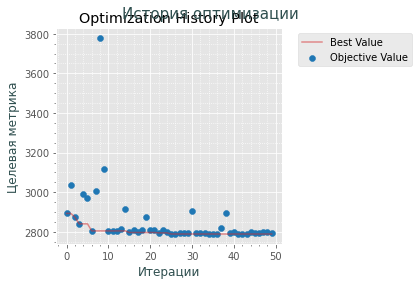

In [30]:
# Определение категориальных признаков
categorical_features = ['wmi', 'restraint', 'model', 'engine', 'plant', 'year']

# Создание объекта CatBoostRegressor
catboost = CatBoostRegressor(random_state=RANDOM, thread_count=-1, verbose=0)

# Определяем функцию для оптимизации
def objective(trial):
    # Определяем параметры для подбора
    iterations = trial.suggest_int('iterations', 250, 600)
    depth = trial.suggest_int('depth', 2, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.08, step=0.01)
    # Создаем модель с определенными параметрами
    model = CatBoostRegressor(iterations=iterations,
                              depth=depth,
                              learning_rate=learning_rate,
                              random_state=RANDOM,
                              silent=True,
                              cat_features=categorical_features) # Указываем категориальные признаки

    # Оцениваем качество модели с помощью кросс-валидации
    score = (cross_val_score(model,
                             features_train,
                             target_train,
                             cv=kf,
                             scoring='neg_mean_squared_error', n_jobs=-1).mean() * -1) ** 0.5

    # Возвращаем среднее значение метрики
    return score

# Создаем объект Study и запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Лучшие параметры:', study.best_params)
print('Лучшее значение метрики:', study.best_value)

# Создаем датафрейм с значениями гиперпараметров и метрикой
results = pd.DataFrame({'iterations': [],
                       'depth': [],
                        'learning_rate': [],
                        'score': []})
# Заполняем данными из best_trials
for trial in study.best_trials:
    params = trial.params
    params['score'] = trial.value
    results = results.append(params, ignore_index=True)

# Сортируем датафрейм по убыванию значения метрики
results = results.sort_values(by='score', ascending=False)

# Выводим 10 лучших моделей
display(results.head(10))

# Создание графика важности параметров с помощью Optuna
importance_dict = optuna.importance.get_param_importances(study)
# Извлечение ключей и значений из словаря
keys = list(importance_dict.keys())
values = list(importance_dict.values())
# Создание горизонтального графика
plt.figure(figsize=(15, 5))
plt.barh(keys, values, color='tab:blue')
# Настройка графика
plt.xlabel('Важность гиперпараметров', fontsize=12, color='DarkSlateGray')
plt.ylabel('Гиперпараметры', fontsize=12, color='DarkSlateGray')
plt.suptitle('Важность гиперпараметров', fontsize=15, color='DarkSlateGray')
# Добавление минорных делений и сетки
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.grid(True)
# Показать график
plt.show()

#  Создаём график истории оптимизации
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.xlabel('Итерации',
           fontsize=12,
           color='DarkSlateGray')
plt.ylabel('Целевая метрика',
           fontsize=12,
           color='DarkSlateGray')
plt.suptitle('История оптимизации \n \n',
             fontsize=15,
             color='DarkSlateGray')
plt.minorticks_on()
plt.grid(which='minor',
         linestyle=':')
plt.grid(True)
plt.show()

In [ ]:
# Определение категориальных признаков
cat_features_indices = [df.columns.get_loc(col) for col in ['wmi', 'restraint', 'model', 'engine', 'plant', 'year']]

# Определение параметров для поиска
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Создание объекта CatBoostRegressor
catboost = CatBoostRegressor(random_state=RANDOM, thread_count=-1, verbose=0)

# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=catboost, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=2,
                                   random_state=RANDOM, n_jobs=-1)

# Проведение поиска
random_search.fit(features_train, target_train)

# Вывод лучших параметров
print("Лучшие параметры: ", random_search.best_params_)

# Оценка модели с лучшими параметрами
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM)
cv_RMSE_LR = (cross_val_score(random_search.best_estimator_,
                              features_train,
                              target_train,
                              cv=kf,
                              scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Значение метрики:', cv_RMSE_LR)

In [ ]:
fsdhdfsdfhsdfhsdhsdfhfsdhhsrthtrhtrjytjkytfjkfkgkyutkuykuylyuliuhluihl;h;ij;oiuoioih;oihu;yuiuy;hj;hiu

In [ ]:
# df[df.duplicated(keep=False)].sort_values('model')

In [ ]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM)

In [ ]:
%%time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyRegressor
from time import time

# Предполагается, что df - это ваш DataFrame
# df = pd.read_csv('your_data.csv') # Если данные загружаются из файла

# Создание экземпляра LabelEncoder
le = LabelEncoder()

# Преобразование строковых признаков в числовые
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Разделение данных на признаки (X) и целевую переменную (y)
X = df.drop('price', axis=1)
y = df['price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование цен на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


In [ ]:
%%time
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)

# Прогнозирование цен на тестовых данных
y_pred_dummy = dummy_regressor.predict(X_test)

# Вычисление MSE и R^2 для DummyRegressor
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f'Mean Squared Error for DummyRegressor: {mse_dummy}')
print(f'R^2 Score for DummyRegressor: {r2_dummy}')

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Предполагается, что X_train и y_train уже определены

# Определение категориальных признаков
categorical_features = ['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant', 'vis'] # Замените на имена ваших категориальных столбцов

# Создание OneHotEncoder для категориальных признаков
encoder = OneHotEncoder()

# Создание ColumnTransformer для применения OneHotEncoder к категориальным признакам
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features)],
    remainder='passthrough')

# Создание пайплайна с препроцессором и моделью XGBRegressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor())])

# Кросс-валидация с использованием пайплайна
cv = cross_validate(pipeline, X_train, y_train, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'])

# Вывод результатов
print('RMSE:', -cv['test_neg_root_mean_squared_error'].mean().round(4))
print('MAPE:', -cv['test_neg_mean_absolute_percentage_error'].mean().round(4))

In [ ]:
values = []
for obj in data_re.finditer(example):
    values.append(obj.groupdict())

values [:1]

### 